In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_consumption():
    consumption_df = pd.read_csv('../raw_data/Consumption_Cleaned.csv')
    consumption_df_only_EU = consumption_df[consumption_df['EU?']].loc[:,'energy_balance_code':]
    
    unused_cols = ["Availableforfinalconsumption",
                   "Finalconsumption",
                   "Grosselectricityproduction",
                   "Imports",
                   "Inlanddemand",
                   "Netelectricityproduction",
                   "Statisticaldifferences"]
    
    consumption_df_only_EU = consumption_df_only_EU[~consumption_df_only_EU['energy_balance'].isin(unused_cols)]
    
    consumption_df_float = consumption_df_only_EU.loc[:, '1990':'2020'].replace(':',np.nan).astype(float)
    consumption_df_float_complete = pd.merge(consumption_df_only_EU.loc[:, 'energy_balance':'Alpha_2_code'],
                                             consumption_df_float, left_index=True, right_index=True).drop(columns='EU?')
    
    return consumption_df_float_complete

In [3]:
def get_exports(single_countries = False):
    exports_df = pd.read_csv('../raw_data/Exports_Cleaned.csv')
    exports_df_only_EU = exports_df[exports_df['EU?']]
    exports_df_only_EU_elec = exports_df_only_EU[exports_df_only_EU['siec'] == 'E7000']
    exports_df_only_EU_elec = exports_df_only_EU_elec.loc[:,'partner':].drop(columns = ['unit', 'EU?', 'Alpha_3_code'])
    
    exports_df_only_EU_elec_float = exports_df_only_EU_elec.loc[:, '1990':'2020'].replace(':',np.nan).astype(float)
    exports_df_only_EU_elec_float_complete = pd.merge(exports_df_only_EU_elec.loc[:, :'Alpha_2_code'], exports_df_only_EU_elec_float, left_index=True, right_index=True)
    
    exports_by_country = exports_df_only_EU_elec_float_complete.groupby(['Alpha_2_code', 'partner']).sum()
    exports_by_country.reset_index(inplace = True)
    
    exports_by_country = exports_by_country[exports_by_country['partner'] != 'TOTAL']
    
    if single_countries == True:
        exports_by_country_total = exports_by_country.groupby('Alpha_2_code').sum()
        
        return exports_by_country_total
    
    elif single_countries == False:  
        exports_by_country_to_non_EU = exports_by_country[~exports_by_country['partner'].isin(exports_by_country['Alpha_2_code'])]
        
        return exports_by_country_to_non_EU

In [4]:
def get_imports(single_countries = False):
    imports_df = pd.read_csv('../raw_data/Imports_Cleaned.csv')
    imports_df_only_EU = imports_df[imports_df['EU?']]
    imports_df_only_EU_elec = imports_df_only_EU[imports_df_only_EU['siec'] == 'E7000']
    imports_df_only_EU_elec = imports_df_only_EU_elec.loc[:,'partner':].drop(columns = ['unit', 'EU?', 'Alpha_3_code'])
    
    imports_df_only_EU_elec_float = imports_df_only_EU_elec.loc[:, '1990':'2020'].replace(':',np.nan).astype(float)
    imports_df_only_EU_elec_float_complete = pd.merge(imports_df_only_EU_elec.loc[:, :'Alpha_2_code'], imports_df_only_EU_elec_float, left_index=True, right_index=True)
    
    imports_by_country = imports_df_only_EU_elec_float_complete.groupby(['Alpha_2_code', 'partner']).sum()
    imports_by_country.reset_index(inplace = True)
    
    if single_countries == True:
        imports_by_country_total = imports_by_country.groupby('Alpha_2_code').sum()
        
        return imports_by_country_total
    
    elif single_countries == False:  
        #imports_by_country_to_EU = imports_by_country[imports_by_country['partner'].isin(imports_by_country['Alpha_2_code'])]
        imports_by_country_to_non_EU = imports_by_country[~imports_by_country['partner'].isin(imports_by_country['Alpha_2_code'])]
    
        return imports_by_country_to_non_EU

In [5]:
def groupby_quartiles(df, columnname, quartiles_asc):
    df[columnname + '_perc'] = df[columnname]/df[columnname].sum()*100
    cumulative = df[columnname + '_perc'].sort_values(ascending=quartiles_asc).cumsum()
    
    if quartiles_asc == False:
        df['highest_quartile'] = cumulative >= 75
        df['2nd_highest_quartile'] = cumulative.between(50,75, inclusive='left')
        df['2nd_lowest_quartile'] = cumulative.between(25,50, inclusive='left')
        df['lowest_quartile'] = cumulative < 25
    
    elif quartiles_asc == True:
        df['lowest_quartile'] = cumulative <= 25
        df['2nd_lowest_quartile'] = cumulative.between(25,50, inclusive='right')
        df['2nd_highest_quartile'] = cumulative.between(50,75, inclusive='right')
        df['highest_quartile'] = cumulative > 75
    
    df['quartile'] = (df.iloc[:, 1:] == 1).idxmax(1)
    df.set_index('quartile',inplace=True)
    
    df = df.loc[:,'1990':'2020']
    df = df.groupby('quartile').sum()
    
    return df

In [11]:
def prepare_consumption_and_export(single_countries = False, get_quartiles = True, quartiles_asc = False):
    cons_df = get_consumption()
    exp_df = get_exports(single_countries=single_countries)
    
    cons_df_by_energy_bal = pd.DataFrame(cons_df.groupby('energy_balance').sum())
    
    if single_countries == False:
        # replace total exports with exports to non-EU countries
        cons_df_by_energy_bal.loc[['Exports']] = exp_df.loc[:,'1990':].sum().values
    
    if get_quartiles == True:
        cons_df_by_energy_bal = groupby_quartiles(cons_df_by_energy_bal, '2019', quartiles_asc=quartiles_asc)
    
    return cons_df_by_energy_bal
    

In [12]:
cons_exp_quart_desc = prepare_consumption_and_export(quartiles_asc=False)

<AxesSubplot:>

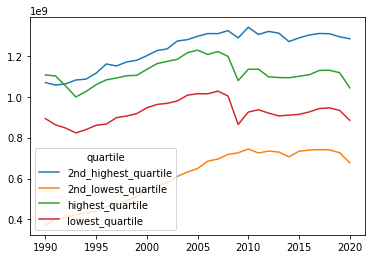

In [13]:
cons_exp_quart_desc.T.plot()

In [14]:
cons_exp_quart_asc = prepare_consumption_and_export(quartiles_asc=True)

<AxesSubplot:>

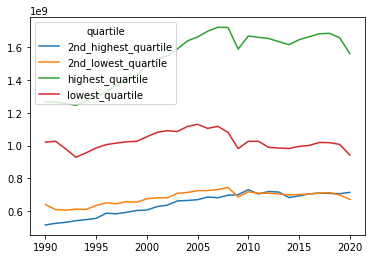

In [15]:
cons_exp_quart_asc.T.plot()